# ML Практическая работа 4
## Мурадян Денис

### Decision Tree and Random Forest

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("denismuradyan/cleaned-dataset-of-used-cars")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cleaned-dataset-of-used-cars


In [2]:
import pandas as pd

df = pd.read_csv(f"{path}/cleaned_data_used_cars.csv")
df.head()

,id,price,year,condition,cylinders,odometer,title_status,description,posting_date,fuel_electric,...,transmission_manual,transmission_other,drive_fwd,drive_rwd,state_freq,region_freq,type_freq,paint_color_freq,te_model_oof,te_manufacturer_oof
0,7316356412,15000,2013,3,6,128000.0,0.0,2013 F-150 XLT V6 4 Door. Good condition. Leve...,2021-05-03 19:02:03,False,...,False,False,False,True,0.012329,0.000328,0.105321,0.209170,20228.583361,20136.757536
1,7316343444,27990,2012,2,8,68696.0,0.0,Carvana is the safer way to buy a car During t...,2021-05-03 18:41:25,False,...,False,True,False,False,0.012329,0.000328,0.126077,0.209170,24936.745669,24228.390664
2,7316304717,34590,2016,2,6,29499.0,0.0,Carvana is the safer way to buy a car During t...,2021-05-03 17:41:33,False,...,False,True,False,False,0.012329,0.000328,0.126077,0.148408,25099.600519,19914.615212
3,7316285779,35000,2019,3,6,43000.0,0.0,Selling my 2019 Toyota Tacoma TRD Off Road Dou...,2021-05-03 17:12:59,False,...,False,False,False,False,0.012329,0.000328,0.105321,0.095670,21119.239527,16356.129063
4,7316257769,29990,2016,2,6,17302.0,0.0,Carvana is the safer way to buy a car During t...,2021-05-03 16:31:14,False,...,False,True,False,False,0.012329,0.000328,0.126077,0.105005,22501.109375,20019.638000


**Данные:** табличные данные объявлений о продаже авто (продолжение ДЗ-1/2/3)  
**Задача:** бинарная классификация - `price > median(price)`.

## Цели работы
- Сравнить интерпретируемую модель **Decision Tree** и ансамблевую модель **Random Forest** на наших подготовленных признаках.
- Понять, как гиперпараметры влияют на качество и переобучение.
- Подобрать гиперпараметры с помощью **Optuna** и оценить прирост качества.
- Построить графики деревьев и важностей признаков.  
- (Опционально) Сравнить Optuna с **GridSearchCV**.

## Задачи
1) Краткая теоретическая справка по DT и RF.  
2) Подготовка данных: берём готовый пайплайн из ДЗ-1-2-3 (19 признаков, target как в прошлых работах).  
3) Базовый **DecisionTreeClassifier** - метрики на валидации.  
4) Базовый **RandomForestClassifier** - метрики + важности признаков.  
5) Единые метрики качества: `accuracy`, `macro F1`, `ROC-AUC` + `confusion_matrix`.  
6) **Optuna** для DT и RF (оптимизируем `macro F1` на valid).  
7) Визуализации: `plot_tree` для DT и одного дерева из RF + графики важностей.  
8) Сравнение: DT vs RF, до/после Optuna; лучшую(ие) - финально на test.  
9) (доп) **GridSearchCV** и сравнение с Optuna.

In [3]:
import warnings, os, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

## Теоретическая справка

### Дерево решений (Decision Tree)
Дерево решений - это модель, которая строит **иерархию простых правил** вида «если признак `x_j` <= порога, идём влево, иначе - вправо». Такой каскад разбиений **рекурсивно** делит пространство признаков на области, внутри которых объекты в среднем однородны по целевому классу. Лист дерева хранит **распределение классов** (доли объектов каждого класса); предсказание - либо **большинство в листе**, либо **оценка вероятности** как эта доля.

Интуитивно это похоже на пошаговую сегментацию данных: каждое разбиение резко упрощает задачу и концентрирует «похожих» объекты вместе. За счёт такой пошаговой декомпозиции дерево:
- естественно работает с **нелинейностями** и **взаимодействиями** признаков;
- **не требует масштабирования** и легко переваривает смешанные типы (числовые/бинарные/упорядоченные категориальные);
- даёт **прозрачную интерпретацию**: путь от корня к листу - это читаемое объяснение решения.

Ограничения: одиночное дерево имеет высокую **дисперсию** (сильно зависит от выборки); небольшие изменения в данных могут заметно менять структуру дерева. Также «глубокие» деревья склонны подгоняться под шум и ловить случайные закономерности.

### Случайный лес (Random Forest)
Случайный лес - это **ансамбль** деревьев решений, каждое из которых обучено на слегка разных данных и признаках. Конструкция включает:
1) **Бутстреп**: для каждого дерева берётся случайная подвыборка объектов с возвращением (разные «взгляды» на данные).  
2) **Случайные подмножества признаков** при построении разбиений (деревья менее похожи друг на друга).

Ключевой эффект - **усреднение** предсказаний множества разнородных деревьев резко снижает дисперсию и делает итоговую модель **устойчивой** к шуму. На практике лес даёт сильный «из коробки» результат на табличных данных, сохраняет возможность **оценивать важность признаков** (какие признаки сильнее всего влияют на решения) и обычно обгоняет одиночное дерево по качеству. Дополнительно в лесу можно использовать **внутреннюю проверку** по out-of-bag-наборам (объекты, не попавшие в бутстреп конкретного дерева), чтобы объективно оценивать обобщающую способность без выделения валидации.

Ограничения: хуже «локальная» интерпретируемость (одно решение - это усреднение по многим деревьям), более высокая вычислительная стоимость и память. При крайне высокой корреляции деревьев выигрыш от ансамблирования уменьшается - поэтому важна разнотипность деревьев за счёт случайности.

## Подготовка данных

Здесь берём тот же подготовленный датасет из ДЗ-2 и повторяем ключевые шаги с одной важной поправкой: **для деревьев решений и случайного леса масштабирование не требуется**, поэтому скейлер не применяем.

**Шаги:**
1. **Удаление служебных признаков:**  
   `id` - тех. идентификатор;  
   `description` - текст (в этой работе не используем);  
   `posting_date` - дата публикации (не нужна для текущей постановки).

2. **Приведение форматов:**  
   булевы индикаторы (`fuel_*`, `transmission_*`, `drive_*`) - `int` (0/1).

3. **Чистка редких пропусков:**  
   удаляем строки с `NaN` в `title_status` (их очень мало - не повлияют на распределения).

4. **Целевая переменная:**  
   бинарная классификация - `target = (price > median(price))`.  
   После создания таргета **исходную `price` удаляем** из признаков, чтобы не «подглядывать» в ответ.

5. **Проверка дисбаланса:**  
   распределение классов, `IR` (imbalance ratio), baseline-точность (всегда предсказывать большинство).

6. **Разбиение на выборки:**  
   `train/valid/test = 70/15/15`, стратификация по `target`, `random_state=42`.  
   Масштабирование **не выполняем** - деревьям масштаб не нужен.

In [4]:
# удалим ненужные признаки
df = df.drop(columns=['id', 'description', 'posting_date'])

# приведем булевы признаки к int (0/1)
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

df = df.dropna(subset=['title_status'])
print("Количество пропусков в каждом признаке:")
print(df.isna().sum())

# формируем целевую переменную
median_price = df['price'].median()
df['target'] = (df['price'] > median_price).astype(int)

# удалим исходную цену, чтобы она не участвовала в обучении как признак
df = df.drop(columns=['price'])


TARGET = 'target'
vc_abs = df[TARGET].value_counts().sort_index()
vc_rel = df[TARGET].value_counts(normalize=True).sort_index()

n_total = int(vc_abs.sum())
n0, n1 = int(vc_abs.get(0, 0)), int(vc_abs.get(1, 0))
p0, p1 = float(vc_rel.get(0, 0.0)), float(vc_rel.get(1, 0.0))

majority_class = 0 if p0 >= p1 else 1
majority_share = max(p0, p1)
minority_share = min(p0, p1)
imbalance_ratio = (majority_share / minority_share) if minority_share > 0 else np.inf
baseline_acc = majority_share

print("\n=== Распределение целевой переменной ===")
print(f"Всего объектов: {n_total}")
print(f"Класс 0: {n0} ({p0:.3f})")
print(f"Класс 1: {n1} ({p1:.3f})")
print(f"Imbalance Ratio (IR): {imbalance_ratio:.3f}")
print(f"Baseline Accuracy (всегда предсказывать класс {majority_class}): {baseline_acc:.3f}")

Количество пропусков в каждом признаке:
price                  0
year                   0
condition              0
cylinders              0
odometer               0
title_status           0
fuel_electric          0
fuel_gas               0
fuel_hybrid            0
fuel_other             0
transmission_manual    0
transmission_other     0
drive_fwd              0
drive_rwd              0
state_freq             0
region_freq            0
type_freq              0
paint_color_freq       0
te_model_oof           0
te_manufacturer_oof    0
dtype: int64

=== Распределение целевой переменной ===
Всего объектов: 173566
Класс 0: 86876 (0.501)
Класс 1: 86690 (0.499)
Imbalance Ratio (IR): 1.002
Baseline Accuracy (всегда предсказывать класс 0): 0.501


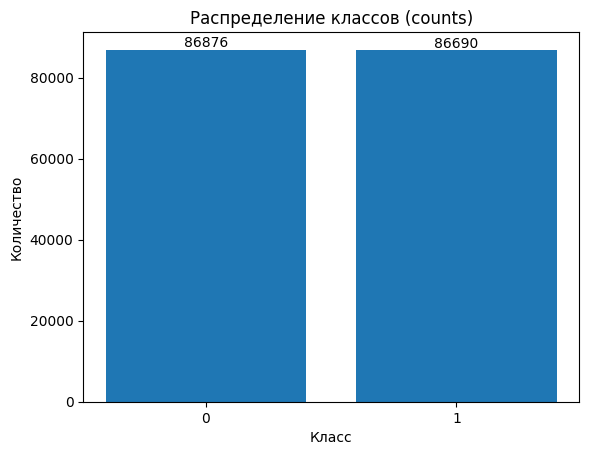

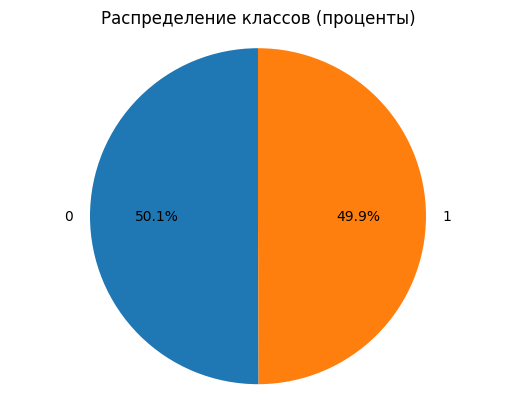

In [5]:
plt.figure()
plt.bar(['0', '1'], [n0, n1])
plt.title('Распределение классов (counts)')
plt.xlabel('Класс')
plt.ylabel('Количество')
for x, y in zip(['0','1'], [n0, n1]):
    plt.text(x, y, str(y), ha='center', va='bottom')
plt.show()

plt.figure()
plt.pie([n0, n1], labels=['0','1'], autopct='%1.1f%%', startangle=90)
plt.title('Распределение классов (проценты)')
plt.axis('equal')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

df_temp, df_test = train_test_split(
    df,
    test_size=0.15,
    shuffle=True,
    random_state=RANDOM_STATE,
    stratify=df[TARGET]
)

df_train, df_valid = train_test_split(
    df_temp,
    test_size=0.1765,  # 0.1765 * 0.85 ≈ 0.15 -> итог 70/15/15
    shuffle=True,
    random_state=RANDOM_STATE,
    stratify=df_temp[TARGET]
)

# Признаки и таргет
feature_cols = [c for c in df.columns if c != TARGET]
X_train, y_train = df_train[feature_cols].copy(), df_train[TARGET].copy()
X_valid, y_valid = df_valid[feature_cols].copy(), df_valid[TARGET].copy()
X_test,  y_test  = df_test[feature_cols].copy(),  df_test[TARGET].copy()

print("Train shape:", X_train.shape)
print("Valid shape:", X_valid.shape)
print("Test shape:", X_test.shape)

Train shape: (121491, 19)
Valid shape: (26040, 19)
Test shape: (26035, 19)


## Decision Tree (DT): подбор гиперпараметров и обучение

1) Подбираем гиперпараметры с помощью **Optuna**, оптимизируя `macro F1` на валидации.  
2) Обучаем модель с лучшими параметрами на train.  
3) Считаем метрики на train и valid, строим матрицу ошибок, важности признаков и фрагмент дерева (`plot_tree` для первых уровней).

**Гиперпараметры (поиск):**  
- `criterion {gini, entropy, log_loss}`  
- `max_depth {None} v [3, 40]`  
- `min_samples_split [2, 50]`  
- `min_samples_leaf [1, 30]`  
- `max_features {None} v (0.2…1.0)`  
- `ccp_alpha [0.0, 0.02]`

> Тестовую выборку (**test**) пока не трогаем - используем её позже для финальной проверки

In [10]:
import optuna
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

def objective_dt(trial):
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    use_max_depth = trial.suggest_categorical("use_max_depth", [True, False])
    max_depth = trial.suggest_int("max_depth", 3, 40) if use_max_depth else None
    min_samples_split = trial.suggest_int("min_samples_split", 2, 50)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 30)
    use_max_features = trial.suggest_categorical("use_max_features", [True, False])
    max_features = trial.suggest_float("max_features", 0.2, 1.0) if use_max_features else None
    ccp_alpha = trial.suggest_float("ccp_alpha", 0.0, 0.02)

    clf = DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        ccp_alpha=ccp_alpha
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    return f1_score(y_valid, y_pred, average="macro")

study_dt = optuna.create_study(direction="maximize", study_name="DT_opt")
study_dt.optimize(objective_dt, n_trials=60, show_progress_bar=True)

print("Лучший macro F1 (valid):", round(study_dt.best_value, 4))
print("Параметры:")
for k, v in study_dt.best_params.items():
    print(f"{k}: {v}")

[I 2025-10-16 10:44:56,785] A new study created in memory with name: DT_opt


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-10-16 10:44:57,455] Trial 0 finished with value: 0.9156291372419962 and parameters: {'criterion': 'entropy', 'use_max_depth': True, 'max_depth': 20, 'min_samples_split': 49, 'min_samples_leaf': 4, 'use_max_features': True, 'max_features': 0.7438980831365312, 'ccp_alpha': 0.00013386875873203864}. Best is trial 0 with value: 0.9156291372419962.
[I 2025-10-16 10:44:58,312] Trial 1 finished with value: 0.865536208708344 and parameters: {'criterion': 'gini', 'use_max_depth': False, 'min_samples_split': 38, 'min_samples_leaf': 27, 'use_max_features': False, 'ccp_alpha': 0.005791789421053373}. Best is trial 0 with value: 0.9156291372419962.
[I 2025-10-16 10:44:59,250] Trial 2 finished with value: 0.8667754135889463 and parameters: {'criterion': 'entropy', 'use_max_depth': True, 'max_depth': 38, 'min_samples_split': 26, 'min_samples_leaf': 1, 'use_max_features': False, 'ccp_alpha': 0.018267167361692396}. Best is trial 0 with value: 0.9156291372419962.
[I 2025-10-16 10:45:00,113] Trial 

In [11]:
# обучение decision tree с лучшими гиперпараметрами
bp = study_dt.best_params
best_dt = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    criterion=bp["criterion"],
    max_depth=(bp["max_depth"] if bp["use_max_depth"] else None),
    min_samples_split=bp["min_samples_split"],
    min_samples_leaf=bp["min_samples_leaf"],
    max_features=(bp["max_features"] if bp["use_max_features"] else None),
    ccp_alpha=bp["ccp_alpha"]
)
best_dt.fit(X_train, y_train)

print(best_dt)

DecisionTreeClassifier(ccp_alpha=2.030162189372249e-05, criterion='entropy',
                       max_depth=17, max_features=0.5881114159796094,
                       min_samples_leaf=14, min_samples_split=25,
                       random_state=42)



[DT(best) train] accuracy=0.9369 | macroF1=0.9369 | roc_auc=0.9882
              precision    recall  f1-score   support

           0     0.9330    0.9415    0.9372     60811
           1     0.9408    0.9323    0.9365     60680

    accuracy                         0.9369    121491
   macro avg     0.9369    0.9369    0.9369    121491
weighted avg     0.9369    0.9369    0.9369    121491


[DT(best) valid] accuracy=0.9199 | macroF1=0.9199 | roc_auc=0.9729
              precision    recall  f1-score   support

           0     0.9160    0.9249    0.9204     13034
           1     0.9240    0.9150    0.9195     13006

    accuracy                         0.9199     26040
   macro avg     0.9200    0.9199    0.9199     26040
weighted avg     0.9200    0.9199    0.9199     26040



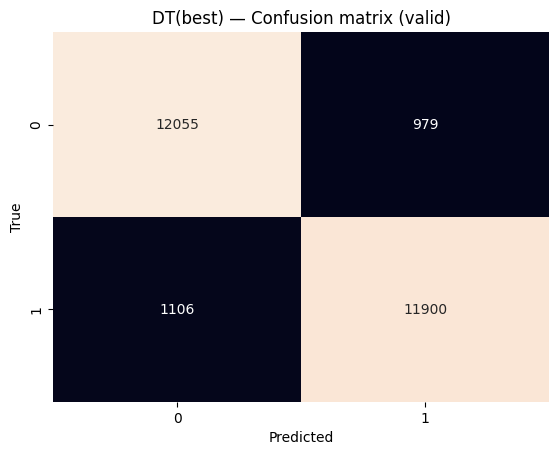

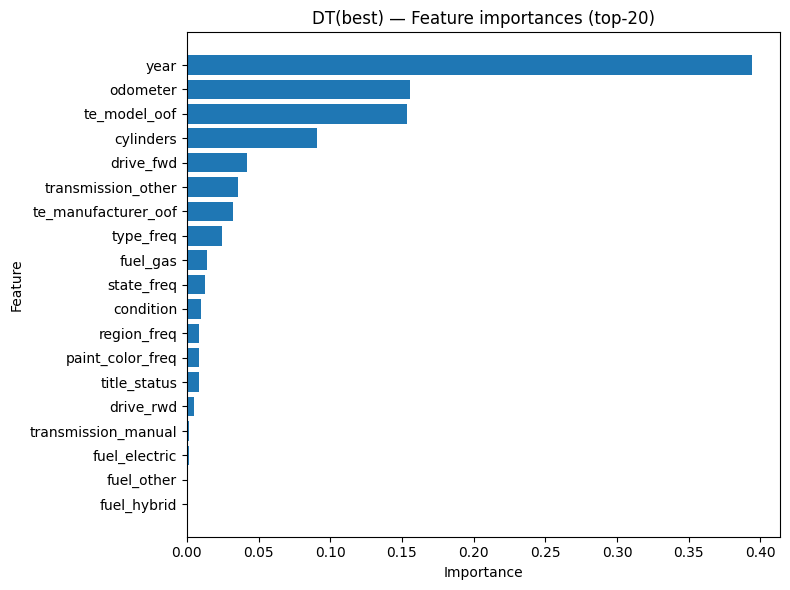

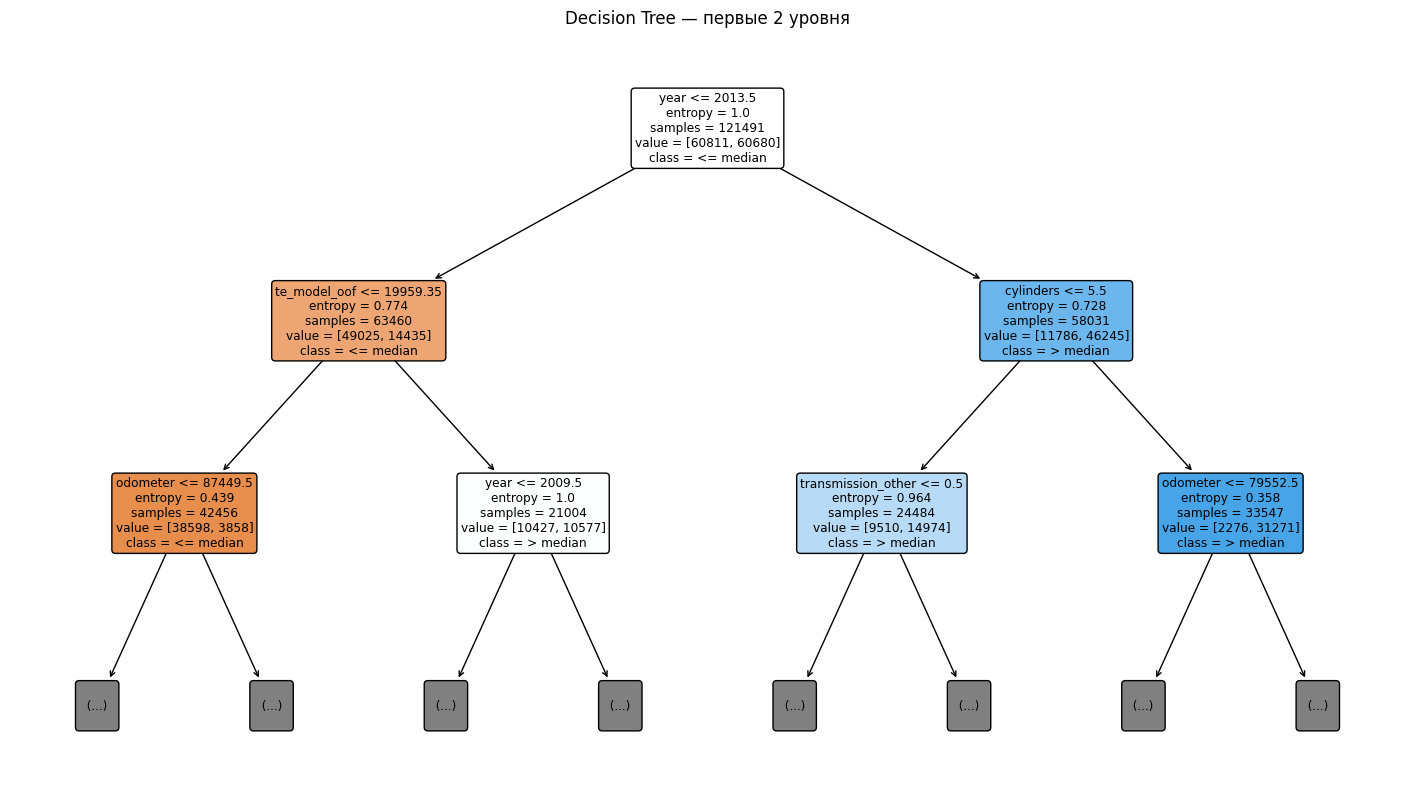

In [16]:
# метрики и визуализации
from typing import Dict
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree

def evaluate_model(clf, X, y, prefix: str = "") -> Dict[str, float]:
    y_pred = clf.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average="macro")
    try:
        y_proba = clf.predict_proba(X)[:, 1]
        roc = roc_auc_score(y, y_proba)
    except Exception:
        roc = float("nan")
    print(f"\n[{prefix}] accuracy={acc:.4f} | macroF1={f1:.4f} | roc_auc={roc:.4f}")
    print(classification_report(y, y_pred, digits=4))
    return {"accuracy": acc, "macro_f1": f1, "roc_auc": roc}

def plot_cm(clf, X, y, title: str):
    cm = confusion_matrix(y, clf.predict(X))
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def plot_feature_importances(clf, feature_names, top_n: int = 20, title: str = ""):
    if not hasattr(clf, "feature_importances_"):
        return
    importances = clf.feature_importances_
    idx = np.argsort(importances)[::-1][:top_n]
    plt.figure(figsize=(8, max(4, top_n * 0.3)))
    plt.barh(np.array(feature_names)[idx][::-1], importances[idx][::-1])
    plt.title(title or "Feature importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

metrics_train_dt = evaluate_model(best_dt, X_train, y_train, prefix="DT(best) train")
metrics_valid_dt = evaluate_model(best_dt, X_valid, y_valid, prefix="DT(best) valid")

plot_cm(best_dt, X_valid, y_valid, title="DT(best) - Confusion matrix (valid)")
plot_feature_importances(best_dt, feature_cols, top_n=20, title="DT(best) - Feature importances (top-20)")

plt.figure(figsize=(18, 10))
plot_tree(
    best_dt,
    feature_names=feature_cols,
    class_names=["<= median", "> median"],
    filled=True,
    rounded=True,
    max_depth=2
)
plt.title("Decision Tree - первые 2 уровня")
plt.show()

### Выводы по Decision Tree (после Optuna)

**Качество**
- `train`: accuracy/F1_macro **0.937**; `valid`: **0.920** - разрыв **0.017** (умеренное переобучение, обобщение хорошее).
- `ROC-AUC (valid)` = **0.973** - высокая разделимость классов.

**Ошибки (valid)**
- TN=12055, FP=979, FN=1106, TP=11900.
- Баланс по классам ровный: recall класса 0 - **0.925**, класса 1 - **0.915**.
- Чуть больше **FN**, чем **FP** - немного чаще недооцениваем дорогие авто

**Что влияет на решения**
- Топ-признаки: **`year`** (доминирует), затем **`odometer`** и **`te_model_oof`**; далее вклад **`cylinders`**, **`drive_fwd`**, **`transmission_other`**, **`te_manufacturer_oof`**, **`type_freq`**.
- Прочие признаки дают небольшой, но стабильный вклад.

**Интерпретация дерева (фрагмент)**
- Корень - порог по **`year`  2013–2014** (новые/старые авто).
- Ветви уточняются по **`cylinders`**, **`odometer`**, **`transmission_other`**, а для старых - по **`te_model_oof`** и **`odometer`**.
- Структура согласуется с важностями: в основе возраст и пробег, далее «сигнал модели».

## Random Forest (RF): подбор гиперпараметров и обучение

Подход:
1) Подбираем гиперпараметры через Optuna по метрике macro F1 на валидации.
2) Обучаем модель с лучшими параметрами на train.
3) Оцениваем на valid: метрики, матрица ошибок, важности признаков. Для наглядности рисуем одно дерево из леса (первые уровни).

Замечание по ресурсам:
- Диапазоны параметров и число попыток в Optuna ограничены, чтобы ускорить расчёты.

Пространство поиска:
- criterion: gini, entropy, log_loss
- n_estimators: 200…500
- max_depth: None или 6…30
- min_samples_split: 2…40
- min_samples_leaf: 1…20
- max_features: доля от 0.3 до 0.9
- bootstrap: True или False

In [18]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

def objective_rf(trial):
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    n_estimators = trial.suggest_int("n_estimators", 200, 500, step=50)
    use_max_depth = trial.suggest_categorical("use_max_depth", [True, False])
    max_depth = trial.suggest_int("max_depth", 6, 30) if use_max_depth else None
    min_samples_split = trial.suggest_int("min_samples_split", 2, 40)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_float("max_features", 0.3, 0.9)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    clf = RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    return f1_score(y_valid, y_pred, average="macro")

study_rf = optuna.create_study(direction="maximize", study_name="RF_opt")
study_rf.optimize(objective_rf, n_trials=40, show_progress_bar=True)

print("Лучший macro F1 (valid):", round(study_rf.best_value, 4))
print("Параметры:")
for k, v in study_rf.best_params.items():
    print(f"{k}: {v}")

[I 2025-10-16 11:41:36,134] A new study created in memory with name: RF_opt


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-10-16 11:42:36,687] Trial 0 finished with value: 0.9372477720692005 and parameters: {'criterion': 'entropy', 'n_estimators': 500, 'use_max_depth': False, 'min_samples_split': 24, 'min_samples_leaf': 20, 'max_features': 0.4079413235185914, 'bootstrap': False}. Best is trial 0 with value: 0.9372477720692005.
[I 2025-10-16 11:43:56,347] Trial 1 finished with value: 0.938707533706665 and parameters: {'criterion': 'gini', 'n_estimators': 450, 'use_max_depth': False, 'min_samples_split': 13, 'min_samples_leaf': 17, 'max_features': 0.6142568066257819, 'bootstrap': False}. Best is trial 1 with value: 0.938707533706665.
[I 2025-10-16 11:45:16,391] Trial 2 finished with value: 0.9381699363000091 and parameters: {'criterion': 'entropy', 'n_estimators': 450, 'use_max_depth': True, 'max_depth': 17, 'min_samples_split': 33, 'min_samples_leaf': 19, 'max_features': 0.6081190267350337, 'bootstrap': False}. Best is trial 1 with value: 0.938707533706665.
[I 2025-10-16 11:45:29,216] Trial 3 finish

In [19]:
bp_rf = study_rf.best_params

best_rf = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_estimators=bp_rf["n_estimators"],
    criterion=bp_rf["criterion"],
    max_depth=(bp_rf["max_depth"] if bp_rf["use_max_depth"] else None),
    min_samples_split=bp_rf["min_samples_split"],
    min_samples_leaf=bp_rf["min_samples_leaf"],
    max_features=bp_rf["max_features"],
    bootstrap=bp_rf["bootstrap"],
    n_jobs=-1
)
best_rf.fit(X_train, y_train)

print(best_rf)

RandomForestClassifier(criterion='entropy', max_features=0.63922236650059,
                       min_samples_split=7, n_estimators=250, n_jobs=-1,
                       random_state=42)



[RF(best) train] accuracy=0.9951 | macroF1=0.9951 | roc_auc=0.9999
              precision    recall  f1-score   support

           0     0.9949    0.9954    0.9951     60811
           1     0.9954    0.9949    0.9951     60680

    accuracy                         0.9951    121491
   macro avg     0.9951    0.9951    0.9951    121491
weighted avg     0.9951    0.9951    0.9951    121491


[RF(best) valid] accuracy=0.9520 | macroF1=0.9520 | roc_auc=0.9906
              precision    recall  f1-score   support

           0     0.9487    0.9557    0.9522     13034
           1     0.9553    0.9483    0.9518     13006

    accuracy                         0.9520     26040
   macro avg     0.9520    0.9520    0.9520     26040
weighted avg     0.9520    0.9520    0.9520     26040



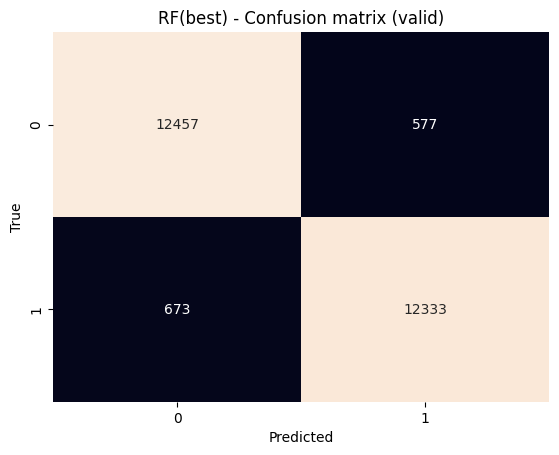

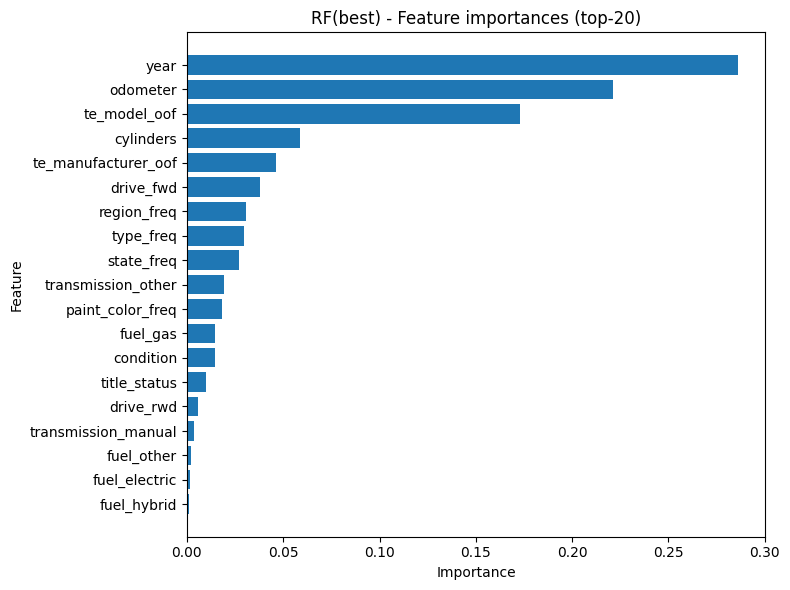

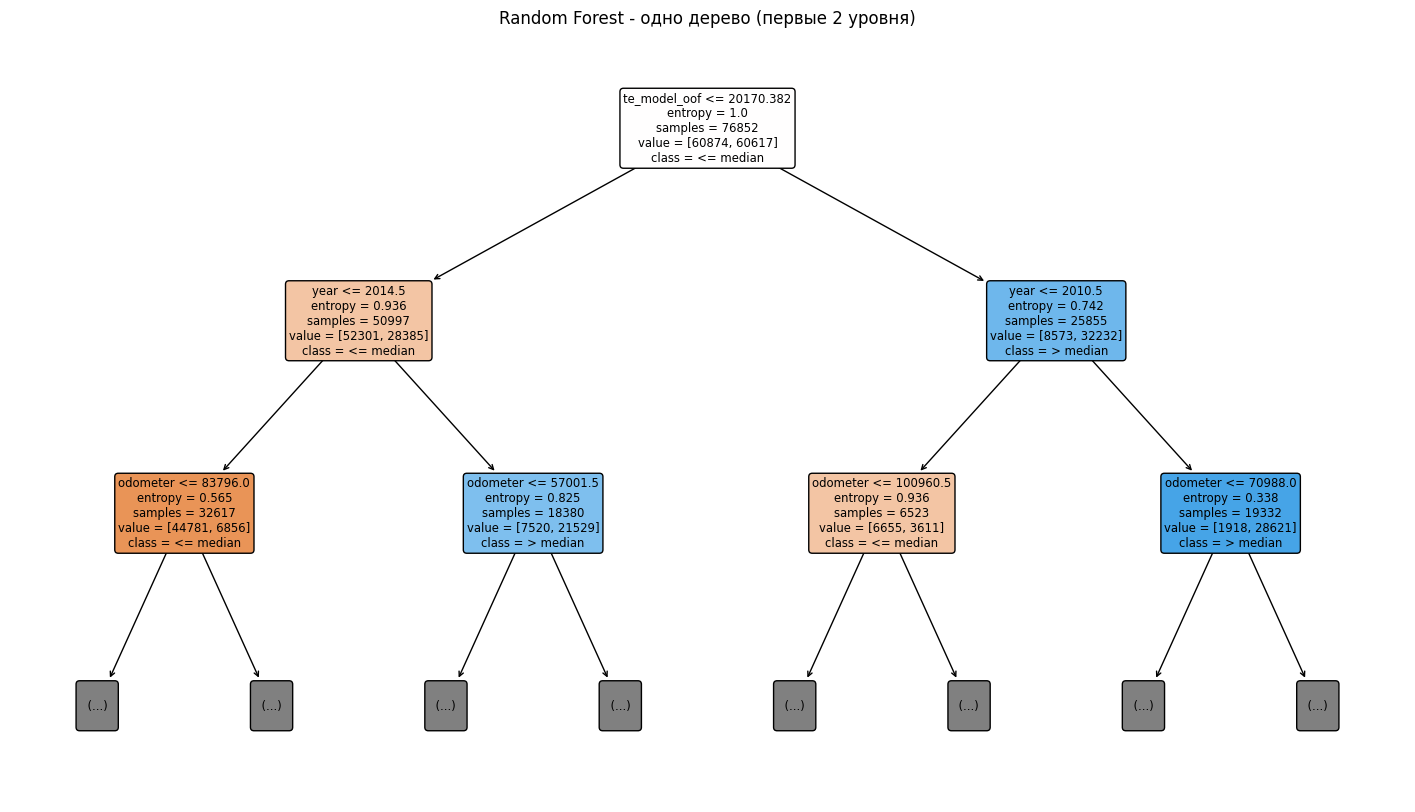

In [20]:
# Используем уже определённые evaluate_model, plot_cm, plot_feature_importances
metrics_train_rf = evaluate_model(best_rf, X_train, y_train, prefix="RF(best) train")
metrics_valid_rf = evaluate_model(best_rf, X_valid, y_valid, prefix="RF(best) valid")

plot_cm(best_rf, X_valid, y_valid, title="RF(best) - Confusion matrix (valid)")
plot_feature_importances(best_rf, feature_cols, top_n=20, title="RF(best) - Feature importances (top-20)")

# Визуализация одного дерева из леса (демонстрационно)
idx_tree = 0 if len(best_rf.estimators_) == 0 else min(0, len(best_rf.estimators_) - 1)
est = best_rf.estimators_[idx_tree]

plt.figure(figsize=(18, 10))
plot_tree(
    est,
    feature_names=feature_cols,
    class_names=["<= median", "> median"],
    filled=True,
    rounded=True,
    max_depth=2
)
plt.title("Random Forest - одно дерево (первые 2 уровня)")
plt.show()

## Выводы по Random Forest (после Optuna)

**Конфигурация**
- criterion = entropy, n_estimators = 250, max_features ≈ 0.64, min_samples_split = 7, bootstrap = True
- Логика настроек: умеренное число деревьев, выбор части признаков при разбиениях и чуть увеличенный min_samples_split дают дополнительную регуляризацию и уменьшают коррелированность деревьев.

**Качество**
- train: accuracy/F1_macro 0.995, valid: 0.952 - разрыв ≈ 0.043. Для леса это нормальный уровень и говорит о стабильной обобщающей способности.
- ROC-AUC (valid) = 0.991 - очень высокая разделимость классов по вероятностям.
- По классам на valid:  
  класс 0 - precision 0.949, recall 0.956;  
  класс 1 - precision 0.955, recall 0.948.  
  Баланс между precision и recall для двух классов почти симметричный.

**Матрица ошибок (valid)**
- TN = 12457, FP = 577, FN = 673, TP = 12333.  
  Ошибок обоих типов немного; FN чуть больше, чем FP, то есть модель немного чаще недооценивает дорогие авто, но разница небольшая.

**Что влияет на решения (feature importances)**
- Явные лидеры: `year` (0.29), `odometer` (0.24), `te_model_oof` (0.17).
- Далее вклад дают `cylinders`, `te_manufacturer_oof`, `drive_fwd`, частотные признаки по региону, типу и штату.
- Остальные фичи вносят небольшой вклад. Профиль важностей согласуется с предметной областью: более новые машины и с меньшим пробегом чаще дороже медианы; target-энкодинги по модели и производителю добавляют сильный сигнал.

**Структура одного дерева из леса (демо)**
- В примерном дереве первый сплит по `te_model_oof`, затем по `year` и `odometer`. Это иллюстрирует разнообразие деревьев: в лесу разные деревья используют разные ранние разбиения, что и даёт устойчивость ансамбля.

**Итог**
- RF после Optuna даёт сильные метрики на valid (F1_macro 0.952, AUC 0.991) при умеренном разрыве с train.
- По сравнению с базовым RF улучшения по F1_macro нет, но модель стала немного более регуляризованной за счёт настроек и остаётся предпочтительным вариантом для финальной проверки на test.

## Базовые модели без Optuna

Чтобы корректно сравнить влияние подбора гиперпараметров, обучим простые версии моделей без оптимизации:
- Decision Tree: конфигурация по умолчанию (только фиксируем random_state).
- Random Forest: умеренный ансамбль на 200 деревьях, остальные параметры по умолчанию.

Считаем на valid те же метрики, что и раньше, и соберем сводную таблицу:
- DT_base, RF_base
- Optuna DT_best и RF_best


[DT_base train] accuracy=0.9999 | macroF1=0.9999 | roc_auc=1.0000
              precision    recall  f1-score   support

           0     0.9999    1.0000    0.9999     60811
           1     1.0000    0.9999    0.9999     60680

    accuracy                         0.9999    121491
   macro avg     0.9999    0.9999    0.9999    121491
weighted avg     0.9999    0.9999    0.9999    121491


[DT_base valid] accuracy=0.9276 | macroF1=0.9276 | roc_auc=0.9278
              precision    recall  f1-score   support

           0     0.9304    0.9245    0.9275     13034
           1     0.9248    0.9307    0.9278     13006

    accuracy                         0.9276     26040
   macro avg     0.9276    0.9276    0.9276     26040
weighted avg     0.9276    0.9276    0.9276     26040



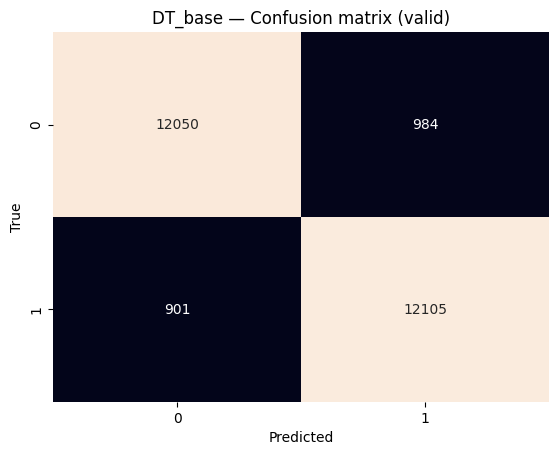

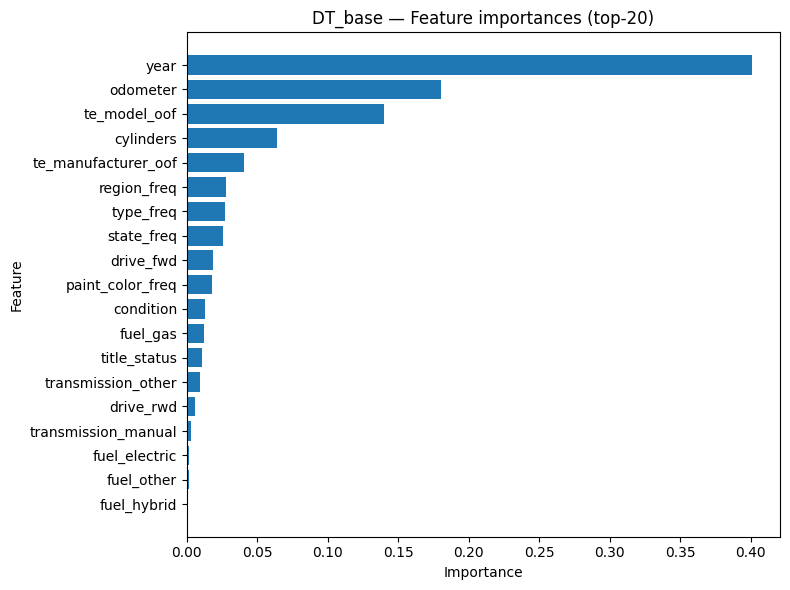

In [21]:
from sklearn.tree import DecisionTreeClassifier

dt_base = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_base.fit(X_train, y_train)

metrics_train_dt_base = evaluate_model(dt_base, X_train, y_train, prefix="DT_base train")
metrics_valid_dt_base = evaluate_model(dt_base, X_valid, y_valid, prefix="DT_base valid")

plot_cm(dt_base, X_valid, y_valid, title="DT_base - Confusion matrix (valid)")
plot_feature_importances(dt_base, feature_cols, top_n=20, title="DT_base - Feature importances (top-20)")


[RF_base train] accuracy=0.9999 | macroF1=0.9999 | roc_auc=1.0000
              precision    recall  f1-score   support

           0     0.9999    0.9999    0.9999     60811
           1     0.9999    0.9999    0.9999     60680

    accuracy                         0.9999    121491
   macro avg     0.9999    0.9999    0.9999    121491
weighted avg     0.9999    0.9999    0.9999    121491


[RF_base valid] accuracy=0.9524 | macroF1=0.9524 | roc_auc=0.9912
              precision    recall  f1-score   support

           0     0.9474    0.9582    0.9527     13034
           1     0.9576    0.9466    0.9521     13006

    accuracy                         0.9524     26040
   macro avg     0.9525    0.9524    0.9524     26040
weighted avg     0.9525    0.9524    0.9524     26040



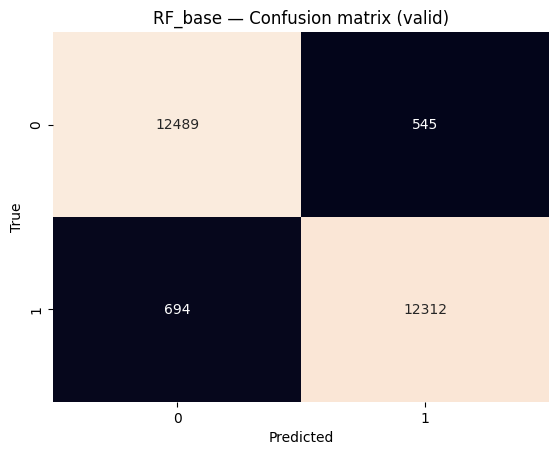

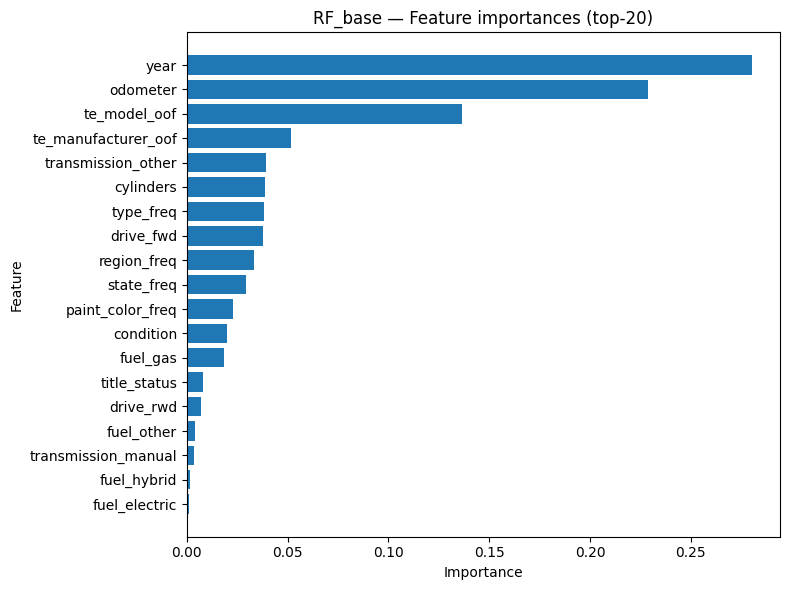

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_base = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_estimators=200,
    n_jobs=-1
)
rf_base.fit(X_train, y_train)

metrics_train_rf_base = evaluate_model(rf_base, X_train, y_train, prefix="RF_base train")
metrics_valid_rf_base = evaluate_model(rf_base, X_valid, y_valid, prefix="RF_base valid")

plot_cm(rf_base, X_valid, y_valid, title="RF_base - Confusion matrix (valid)")
plot_feature_importances(rf_base, feature_cols, top_n=20, title="RF_base - Feature importances (top-20)")

In [23]:
rows = []

def add_row(name, mtrain, mvalid):
    if mtrain is None or mvalid is None:
        return
    rows.append({
        "model": name,
        "train_accuracy": round(mtrain["accuracy"], 4),
        "train_macroF1": round(mtrain["macro_f1"], 4),
        "valid_accuracy": round(mvalid["accuracy"], 4),
        "valid_macroF1": round(mvalid["macro_f1"], 4),
        "valid_roc_auc": None if np.isnan(mvalid["roc_auc"]) else round(mvalid["roc_auc"], 4),
    })

# базовые
add_row("DT_base", metrics_train_dt_base, metrics_valid_dt_base)
add_row("RF_base", metrics_train_rf_base, metrics_valid_rf_base)


add_row("DT_best_optuna", metrics_train_dt, metrics_valid_dt)
add_row("RF_best_optuna", metrics_train_rf, metrics_valid_rf)


results_df = pd.DataFrame(rows)
display(results_df.sort_values("valid_macroF1", ascending=False).reset_index(drop=True))

,model,train_accuracy,train_macroF1,valid_accuracy,valid_macroF1,valid_roc_auc
0,RF_base,0.9999,0.9999,0.9524,0.9524,0.9912
1,RF_best_optuna,0.9951,0.9951,0.9520,0.9520,0.9906
2,DT_base,0.9999,0.9999,0.9276,0.9276,0.9278
3,DT_best_optuna,0.9369,0.9369,0.9199,0.9199,0.9729


## Сравнение моделей: DT vs RF и до/после Optuna

### Качество на валидации
- **RF_base** - F1_macro **0.9524**, ROC-AUC **0.9912** - лучший результат.
- **RF_best_optuna** - F1_macro **0.9520**, ROC-AUC **0.9906** - практически без изменений.
- **DT_base** - F1_macro **0.9276**, ROC-AUC **0.9278**.
- **DT_best_optuna** - F1_macro **0.9199**, ROC-AUC **0.9729**.

Итог по качеству: Random Forest уверенно обгоняет Decision Tree по F1_macro; у дерева после Optuna выше AUC, но ниже F1_macro на фиксированном пороге 0.5.

### Обобщающая способность: разрыв между train и valid
(чем меньше разрыв, тем стабильнее модель)
- У **DT_base** и **RF_base** F1_macro на train ≈ 1.0 при заметно меньшем F1_macro на valid - это **большой generalization gap**.
- **DT_best_optuna** имеет самый маленький разрыв (**0.017**), то есть тюнинг сделал дерево более стабильным.
- Для **RF** разрыв остаётся умеренным (0.043–0.048); Optuna немного сгладила его.

### Типы ошибок (valid, абсолютные числа)
- **RF_base:** TN=12489, FP=545, FN=694, TP=12312.  
- **DT_base:** TN=12050, FP=984, FN=901, TP=12105.  
- **DT_best_optuna:** TN=12055, FP=979, FN=1106, TP=11900.

Наблюдения:
- **RF_base** допускает заметно меньше ошибок обоих типов, чем оба варианта DT.  
- У **DT_best_optuna** стало немного меньше FP по сравнению с DT_base, но выросли FN (чаще недооценивает класс 1).

### Влияние Optuna
- **Decision Tree:**  
  - F1_macro: 0.9276 - **0.9199** (чуть ниже на пороге 0.5),  
  - ROC-AUC: 0.9278 - **0.9729** (значительно выше),  
  - разрыв train–valid: 0.0723 - **0.0170** (модель стала существенно стабильнее).  
  Вывод: Optuna «поджала» дерево (меньше подгонка, лучше ранжирование по вероятностям), но при фиксированном пороге F1_macro снизился.
- **Random Forest:**  
  - F1_macro: **0.9524** - 0.9520 (без улучшения), ROC-AUC: 0.9912 - 0.9906,  
  - разрыв: 0.0475 - 0.0431 (незначительно лучше).  
  Вывод: базовый RF уже близок к оптимуму для наших признаков и бюджета поиска; дополнительный подбор почти ничего не даёт.

## Сравнение с GridSearch

Задача: проверить, даёт ли классический перебор по сетке выигрыш относительно Optuna и базовых настроек.

Подход:
- используем GridSearchCV с `scoring='f1_macro'`, `cv=5`, `n_jobs=-1`;
- после подбора обучаем лучшую модель на train и считаем метрики на valid;
- добавляем строки в сводную таблицу: `DT_grid`, `RF_grid`.

DT_grid best cv f1_macro: 0.9201
DT_grid best params:
ccp_alpha: 0.0
criterion: entropy
max_depth: 20
max_features: 0.8
min_samples_leaf: 1
min_samples_split: 2

[DT_grid train] accuracy=0.9907 | macroF1=0.9907 | roc_auc=0.9998
              precision    recall  f1-score   support

           0     0.9890    0.9924    0.9907     60811
           1     0.9923    0.9890    0.9906     60680

    accuracy                         0.9907    121491
   macro avg     0.9907    0.9907    0.9907    121491
weighted avg     0.9907    0.9907    0.9907    121491


[DT_grid valid] accuracy=0.9261 | macroF1=0.9261 | roc_auc=0.9352
              precision    recall  f1-score   support

           0     0.9255    0.9270    0.9262     13034
           1     0.9267    0.9252    0.9259     13006

    accuracy                         0.9261     26040
   macro avg     0.9261    0.9261    0.9261     26040
weighted avg     0.9261    0.9261    0.9261     26040



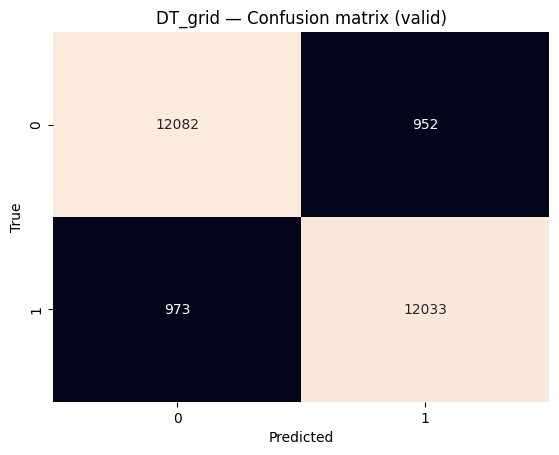

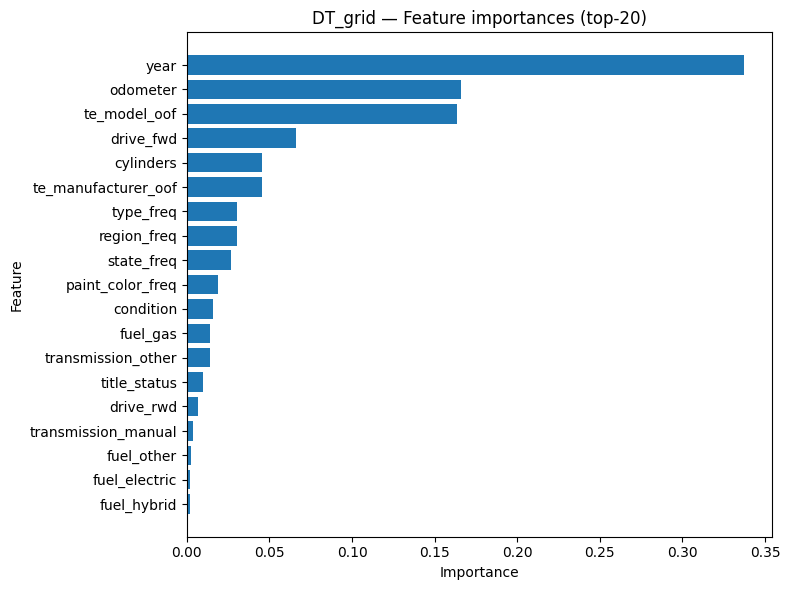

In [28]:
# GridSearchCV для Decision Tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid_dt = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 12, 20],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 5],
    "max_features": [None, 0.8],
    "ccp_alpha": [0.0, 0.002],
}

grid_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid_dt,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    refit=True,
    verbose=0
)
grid_dt.fit(X_train, y_train)

print("DT_grid best cv f1_macro:", round(grid_dt.best_score_, 4))
print("DT_grid best params:")
for k, v in grid_dt.best_params_.items():
    print(f"{k}: {v}")

dt_grid = grid_dt.best_estimator_

metrics_train_dt_grid = evaluate_model(dt_grid, X_train, y_train, prefix="DT_grid train")
metrics_valid_dt_grid = evaluate_model(dt_grid, X_valid, y_valid, prefix="DT_grid valid")

plot_cm(dt_grid, X_valid, y_valid, title="DT_grid - Confusion matrix (valid)")
plot_feature_importances(dt_grid, feature_cols, top_n=20, title="DT_grid - Feature importances (top-20)")

In [33]:
# GridSearchCV для Random Forest
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    "n_estimators": [120],
    "criterion": ["entropy"], # сузили по результатам Optuna
    "max_depth": [None, 16],
    "min_samples_split": [2, 8],
    "min_samples_leaf": [1, 4],
    "max_features": [0.65],
    "bootstrap": [True],
}

rf_base_est = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    max_samples=0.8
)

grid_rf = GridSearchCV(
    estimator=rf_base_est,
    param_grid=param_grid_rf,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    refit=True,
    verbose=0
)
grid_rf.fit(X_train, y_train)

print("RF_grid (fast) best cv f1_macro:", round(grid_rf.best_score_, 4))
print("RF_grid (fast) best params:")
for k, v in grid_rf.best_params_.items():
    print(f"{k}: {v}")

RF_grid (fast) best cv f1_macro: 0.944
RF_grid (fast) best params:
bootstrap: True
criterion: entropy
max_depth: None
max_features: 0.65
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 120



[RF_grid(train)] accuracy=0.9999 | macroF1=0.9999 | roc_auc=1.0000
              precision    recall  f1-score   support

           0     1.0000    0.9999    0.9999     60811
           1     0.9999    1.0000    0.9999     60680

    accuracy                         0.9999    121491
   macro avg     0.9999    0.9999    0.9999    121491
weighted avg     0.9999    0.9999    0.9999    121491


[RF_grid(valid)] accuracy=0.9546 | macroF1=0.9546 | roc_auc=0.9911
              precision    recall  f1-score   support

           0     0.9512    0.9584    0.9548     13034
           1     0.9580    0.9507    0.9543     13006

    accuracy                         0.9546     26040
   macro avg     0.9546    0.9546    0.9546     26040
weighted avg     0.9546    0.9546    0.9546     26040



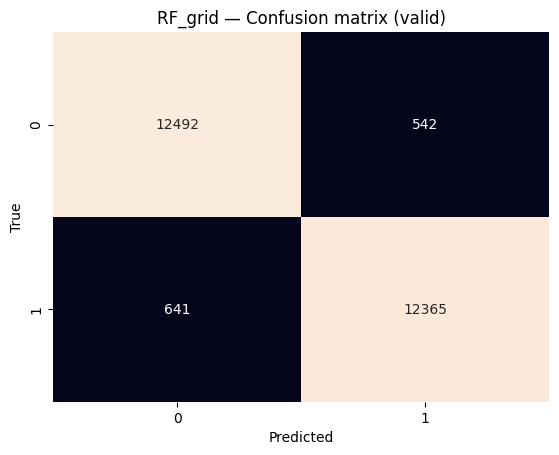

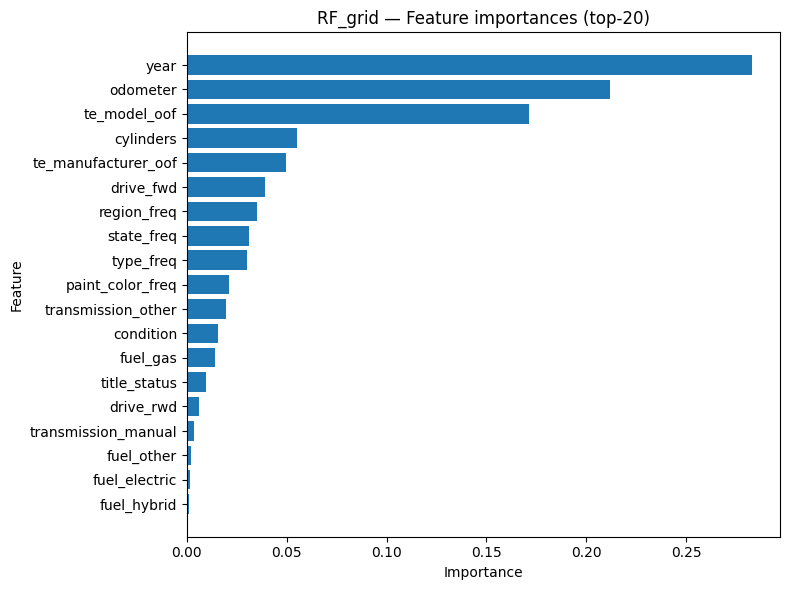

In [36]:
# финальное переобучение на полном train без max_samples и с большим числом деревьев
bp = grid_rf.best_params_
rf_grid_fast_final = RandomForestClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    criterion=bp["criterion"],
    max_depth=bp["max_depth"],
    min_samples_split=bp["min_samples_split"],
    min_samples_leaf=bp["min_samples_leaf"],
    max_features=bp["max_features"],
    bootstrap=bp["bootstrap"],
    n_estimators=300
)
rf_grid_fast_final.fit(X_train, y_train)

metrics_train_rf_grid = evaluate_model(rf_grid_fast_final, X_train, y_train, prefix="RF_grid(train)")
metrics_valid_rf_grid = evaluate_model(rf_grid_fast_final, X_valid, y_valid, prefix="RF_grid(valid)")

plot_cm(rf_grid_fast_final, X_valid, y_valid, title="RF_grid - Confusion matrix (valid)")
plot_feature_importances(rf_grid_fast_final, feature_cols, top_n=20, title="RF_grid - Feature importances (top-20)")

In [37]:
def add_row(name, mtrain, mvalid):
    rows.append({
        "model": name,
        "train_accuracy": round(mtrain["accuracy"], 4),
        "train_macroF1": round(mtrain["macro_f1"], 4),
        "valid_accuracy": round(mvalid["accuracy"], 4),
        "valid_macroF1": round(mvalid["macro_f1"], 4),
        "valid_roc_auc": None if np.isnan(mvalid["roc_auc"]) else round(mvalid["roc_auc"], 4),
    })


rows = results_df.to_dict("records")

add_row("DT_grid", metrics_train_dt_grid, metrics_valid_dt_grid)
add_row("RF_grid", metrics_train_rf_grid, metrics_valid_rf_grid)

results_df = pd.DataFrame(rows)
display(results_df.sort_values("valid_macroF1", ascending=False).reset_index(drop=True))

for name in ["RF_base", "RF_best_optuna", "RF_grid", "DT_base", "DT_best_optuna", "DT_grid"]:
    row = results_df[results_df["model"] == name].iloc[0]
    print(f"{name}: valid F1_macro={row['valid_macroF1']}, AUC={row['valid_roc_auc']}")

,model,train_accuracy,train_macroF1,valid_accuracy,valid_macroF1,valid_roc_auc
0,RF_grid,0.9999,0.9999,0.9546,0.9546,0.9911
1,RF_base,0.9999,0.9999,0.9524,0.9524,0.9912
2,RF_best_optuna,0.9951,0.9951,0.9520,0.9520,0.9906
3,DT_base,0.9999,0.9999,0.9276,0.9276,0.9278
4,DT_grid,0.9907,0.9907,0.9261,0.9261,0.9352
5,DT_best_optuna,0.9369,0.9369,0.9199,0.9199,0.9729


RF_base: valid F1_macro=0.9524, AUC=0.9912
RF_best_optuna: valid F1_macro=0.952, AUC=0.9906
RF_grid: valid F1_macro=0.9546, AUC=0.9911
DT_base: valid F1_macro=0.9276, AUC=0.9278
DT_best_optuna: valid F1_macro=0.9199, AUC=0.9729
DT_grid: valid F1_macro=0.9261, AUC=0.9352


## GridSearch: выводы

- Для Random Forest сетка дала небольшой, но стабильный выигрыш на валидации:  
  **RF_grid F1_macro = 0.9546** против 0.9524 у RF_base и 0.9520 у RF после Optuna.  
  Разрыв train–valid у RF_grid 0.045 (train 0.9999 valid 0.9546) - сопоставим с остальными RF, то есть улучшение не связано с сильной подгонкой.
- Для Decision Tree сетка не превзошла базу:  
  **DT_grid F1_macro = 0.9261** против 0.9276 у DT_base и 0.9199 у DT после Optuna.  
  У DT_grid разрыв train–valid 0.065, что больше, чем у DT после Optuna (0.017). Значит, сетка поджала гиперы слабее, чем Optuna, и дерево осталось более «жёстким».
- Итого по валид.результатам: лучший из всех - **RF_grid**, для дерева разумнее держать **DT_best_optuna** как более стабильный и интерпретируемый вариант.

Все это время мы не трогали выборку `test` - как упоминали выше, используем ее для финальной проверки:

In [39]:
models_to_test = {}

if "best_dt" in locals():
    models_to_test["DT_best_optuna"] = best_dt
if "dt_grid" in locals():
    models_to_test["DT_grid"] = dt_grid

if "best_rf" in locals():
    models_to_test["RF_best_optuna"] = best_rf
# поддержка двух вариантов имени модели из GridSearch (обычный и ускоренный)
if "rf_grid_fast_final" in locals():
    models_to_test["RF_grid"] = rf_grid_fast_final
elif "rf_grid" in locals():
    try:
        models_to_test["RF_grid"] = grid_rf.best_estimator_
    except Exception:
        pass

# при желании добавим и базовые
if "rf_base" in locals():
    models_to_test["RF_base"] = rf_base
if "dt_base" in locals():
    models_to_test["DT_base"] = dt_base

test_rows = []
per_model_metrics = {}
for name, model in models_to_test.items():
    m = evaluate_model(model, X_test, y_test, prefix=f"{name} test")
    per_model_metrics[name] = m
    test_rows.append({
        "model": name,
        "test_accuracy": round(m["accuracy"], 4),
        "test_macroF1": round(m["macro_f1"], 4),
        "test_roc_auc": None if np.isnan(m["roc_auc"]) else round(m["roc_auc"], 4),
    })

test_results_df = pd.DataFrame(test_rows).sort_values("test_macroF1", ascending=False).reset_index(drop=True)
display(test_results_df)


[DT_best_optuna test] accuracy=0.9165 | macroF1=0.9165 | roc_auc=0.9710
              precision    recall  f1-score   support

           0     0.9149    0.9187    0.9168     13031
           1     0.9181    0.9143    0.9162     13004

    accuracy                         0.9165     26035
   macro avg     0.9165    0.9165    0.9165     26035
weighted avg     0.9165    0.9165    0.9165     26035


[DT_grid test] accuracy=0.9221 | macroF1=0.9221 | roc_auc=0.9294
              precision    recall  f1-score   support

           0     0.9217    0.9226    0.9222     13031
           1     0.9224    0.9215    0.9219     13004

    accuracy                         0.9221     26035
   macro avg     0.9221    0.9221    0.9221     26035
weighted avg     0.9221    0.9221    0.9221     26035


[RF_best_optuna test] accuracy=0.9494 | macroF1=0.9494 | roc_auc=0.9894
              precision    recall  f1-score   support

           0     0.9470    0.9521    0.9496     13031
           1     0.9518  

,model,test_accuracy,test_macroF1,test_roc_auc
0,RF_base,0.9525,0.9525,0.9904
1,RF_grid,0.9513,0.9513,0.9900
2,RF_best_optuna,0.9494,0.9494,0.9894
3,DT_grid,0.9221,0.9221,0.9294
4,DT_base,0.9186,0.9186,0.9187
5,DT_best_optuna,0.9165,0.9165,0.9710


## Итоги на test и общий вывод

### Итоги на test
- Лидер на тесте – **Random Forest (base)**: F1_macro 0.9525, ROC-AUC 0.9904.
- **RF_grid**: F1_macro 0.9513, ROC-AUC 0.9900. Чуть ниже, чем у базового, разница минимальна.
- **RF_best_optuna**: F1_macro 0.9494, ROC-AUC 0.9894. Незначительно уступает базе.
- Среди деревьев лучшим стал **DT_grid**: F1_macro 0.9221, ROC-AUC 0.9294.
- **DT_base**: 0.9186, **DT_best_optuna**: 0.9165, но с высоким ROC-AUC 0.9710. Это означает хорошее ранжирование вероятностей, но на пороге 0.5 F1 ниже.

Вывод: расстановка сил совпала с валидацией. Ансамбль стабильно лучше одиночного дерева. Разницы между вариантами RF невелики, базовая конфигурация оказалась лучшей.

### Общий вывод по работе
Обучили Decision Tree и Random Forest, сделали подбор гиперпараметров Optuna и проверили GridSearch.  
Сравнили до и после тюнинга:
- Для **RF** тюнинг дал минимум пользы: базовый вариант уже близок к оптимуму и выиграл на тесте.
- Для **DT** Optuna сделала модель более аккуратной (выше AUC), но по F1_macro лучше сработала простая сетка, а абсолютное качество у дерева заметно ниже, чем у леса.
Финальная модель для задачи – **Random Forest (base)**. Она даёт лучший F1_macro и высокий ROC-AUC